# 1. Install Necessary Libraries

In [1]:
 !pip install tensorflow numpy matplotlib scikit-learn


# Import Libraries

In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, accuracy_score


# 3. Set Random Seed for Reproducibility

In [3]:
np.random.seed(42)
tf.random.set_seed(42)


# 4. Load and Preprocess the Dataset

In [4]:
# Set the paths for the dataset directories
train_dir = 'C:/Users/Admin/Desktop/Wali_Patel_Project/resized_224/train'
valid_dir = 'C:/Users/Admin/Desktop/Wali_Patel_Project/resized_224/validation'
test_dir = 'C:/Users/Admin/Desktop/Wali_Patel_Project/resized_224/test'

# Data augmentation for the training set
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.15,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.15,
    horizontal_flip=True,
    fill_mode="nearest"
)

# Data preprocessing for validation and test sets
valid_datagen = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)

# Data generators
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

valid_generator = valid_datagen.flow_from_directory(
    valid_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(224, 224),
    batch_size=32,
    class_mode='binary',
    shuffle=False
)


Found 1600 images belonging to 2 classes.
Found 384 images belonging to 2 classes.
Found 200 images belonging to 2 classes.


# 5. Load Pre-trained MobileNetV2 and Build the Model

In [5]:
# Load MobileNetV2 with pre-trained weights and without the top layer
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.2),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer=Adam(learning_rate=0.001), 
              loss='binary_crossentropy', 
              metrics=['accuracy'])

# Model summary
model.summary()




9406464/9406464 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   
 tional)                                                         
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 1)                 1281      
                                                                 
Total params: 2259265 (8.62 MB)
Trainable params: 1281 (5.00 KB)
Non-trainable params: 2257984 (8.61 MB)
__________________

# Train the model

In [6]:
history = model.fit(
    train_generator,
    validation_data=valid_generator,
    epochs=10,
    steps_per_epoch=train_generator.samples // train_generator.batch_size,
    validation_steps=valid_generator.samples // valid_generator.batch_size
)


Epoch 1/10


50/50 [==============================] - 64s 1s/step - loss: 0.7168 - accuracy: 0.5675 - val_loss: 0.6755 - val_accuracy: 0.5729
Epoch 2/10
50/50 [==============================] - 45s 907ms/step - loss: 0.6539 - accuracy: 0.6156 - val_loss: 0.6565 - val_accuracy: 0.6094
Epoch 3/10
50/50 [==============================] - 42s 843ms/step - loss: 0.6507 - accuracy: 0.6275 - val_loss: 0.6568 - val_accuracy: 0.6172
Epoch 4/10
50/50 [==============================] - 41s 822ms/step - loss: 0.6518 - accuracy: 0.6394 - val_loss: 0.6191 - val_accuracy: 0.6484
Epoch 5/10
50/50 [==============================] - 41s 823ms/step - loss: 0.6157 - accuracy: 0.6612 - val_loss: 0.6300 - val_accuracy: 0.6380
Epoch 6/10
50/50 [==============================] - 42s 831ms/step - loss: 0.6167 - accuracy: 0.6706 - val_loss: 0.6028 - val_accuracy: 0.6719
Epoch 7/10
50/50 [==============================] - 43s 866ms/step - loss: 0.6129 - accuracy: 0.6656 - val_loss: 0.6014 - val_accuracy: 0.6641


# 7. Evaluate the Model on the Test Set

In [7]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // test_generator.batch_size)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")


6/6 [==============================] - 4s 648ms/step - loss: 0.6125 - accuracy: 0.6823
Test Accuracy: 68.23%


# 8. Plot Training and Validation Accuracy and Loss

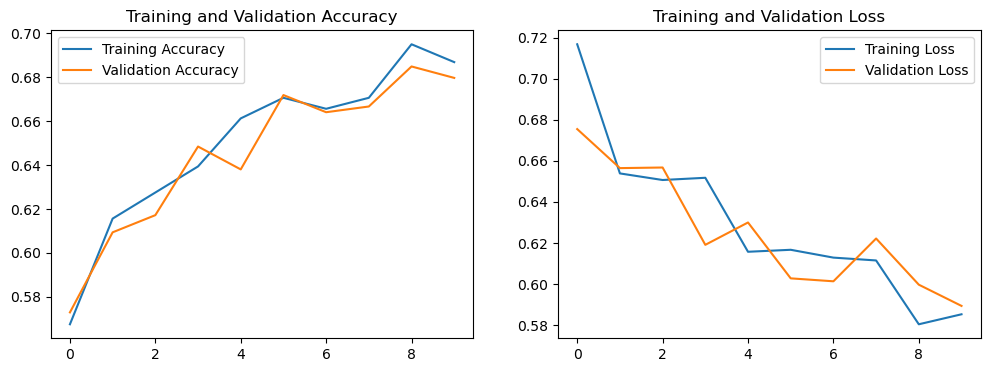

In [8]:
# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.legend()

plt.show()


# 9. Predict and Evaluate the Model on the Test Set

In [9]:
# Predict on the test set
y_pred = model.predict(test_generator)
y_pred = np.round(y_pred).astype(int)

# Confusion matrix
cm = confusion_matrix(test_generator.classes, y_pred)
print('Confusion Matrix')
print(cm)

# Classification report
cr = classification_report(test_generator.classes, y_pred, target_names=test_generator.class_indices.keys())
print('Classification Report')
print(cr)

# ROC-AUC score
roc_auc = roc_auc_score(test_generator.classes, y_pred)
print(f"ROC-AUC Score: {roc_auc:.2f}")


7/7 [==============================] - 4s 443ms/step
Confusion Matrix
[[64 36]
 [26 74]]
Classification Report
              precision    recall  f1-score   support

Cardiomegaly       0.71      0.64      0.67       100
  No Finding       0.67      0.74      0.70       100

    accuracy                           0.69       200
   macro avg       0.69      0.69      0.69       200
weighted avg       0.69      0.69      0.69       200

ROC-AUC Score: 0.69


# 10. Save the Model

In [10]:
# Save the model
model.save('mobilenetv2_cardiomegaly.h5')


C:\Users\Admin\anaconda3\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


# 11. Load the Saved Model

In [11]:
from tensorflow.keras.models import load_model

# Load the saved model
model = load_model('mobilenetv2_cardiomegaly.h5')


# 12 Evaluate the Model on the Test Set

In [12]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator)
print(f'Test Accuracy: {test_accuracy * 100:.2f}%')
print(f'Test Loss: {test_loss:.4f}')


7/7 [==============================] - 7s 518ms/step - loss: 0.6069 - accuracy: 0.6900
Test Accuracy: 69.00%
Test Loss: 0.6069


# 13 Generate Predictions

In [13]:
# Generate predictions on the test set
predictions = model.predict(test_generator)
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

# Print the classification report
from sklearn.metrics import classification_report
report = classification_report(true_classes, predicted_classes, target_names=class_labels)
print(report)

7/7 [==============================] - 4s 427ms/step
              precision    recall  f1-score   support

Cardiomegaly       0.50      1.00      0.67       100
  No Finding       0.00      0.00      0.00       100

    accuracy                           0.50       200
   macro avg       0.25      0.50      0.33       200
weighted avg       0.25      0.50      0.33       200



C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Admin\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


# 14 Confusion Matrix

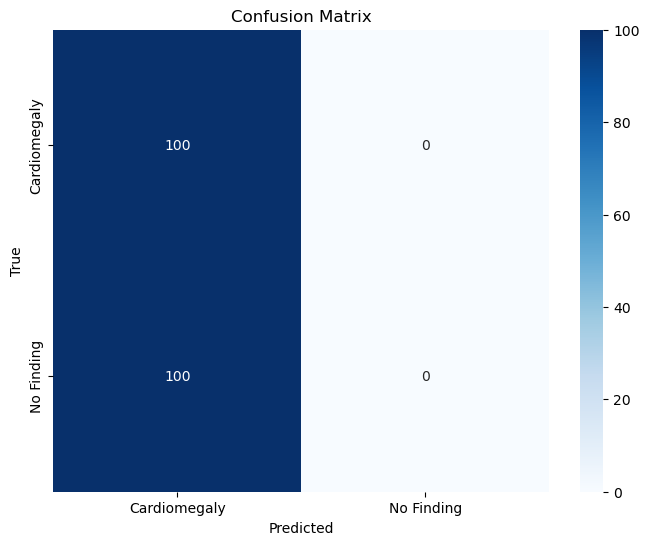

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Generate the confusion matrix
conf_matrix = confusion_matrix(true_classes, predicted_classes)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


# 15 Load and Preprocess the Image

In [15]:
import numpy as np
from tensorflow.keras.preprocessing import image

# Load the image
img_path = 'img2.png'  # Replace with the path to your image
img = image.load_img(img_path, target_size=(224, 224))

# Preprocess the image
img_array = image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
img_array /= 255.0  # Normalize the image (same as training normalization)


# 16 Make a Prediction

In [16]:
# Make the prediction
prediction = model.predict(img_array)

# Interpret the prediction
predicted_class = np.argmax(prediction, axis=1)
class_labels = list(test_generator.class_indices.keys())  # Assuming you used test_generator before
predicted_label = class_labels[predicted_class[0]]

print(f'Predicted Label: {predicted_label}')


1/1 [==============================] - 1s 1s/step
Predicted Label: Cardiomegaly


# 17 Displaying the Image and Prediction

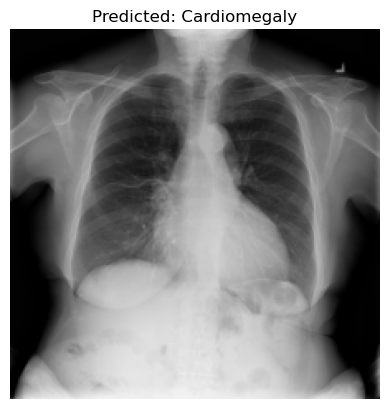

In [17]:
import matplotlib.pyplot as plt

# Display the image with the predicted label
plt.imshow(img)
plt.title(f'Predicted: {predicted_label}')
plt.axis('off')
plt.show()
